In [50]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import os

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Common Problems when Training ML/AI Models (And how to solve them without losing your mind) 

A practical guide for practical python users

## Poor Data Quality 

A ml/ai algorithm is only as good at the data you give it. 
If you give data that contains no meaningful information, you shouldn't be surprized when the algorithm can't get anything out of it. 
However, we've got a whole lot of tips to get around the problems. 
You'll also build up an intutition for how to get around these with practice. 

### Missing Data

Not every piece of data is always recorded. 
If a question is optional on a survey, not everyone is going to anwser. 
Unfortunately, models tend to get a little angry with a NaN or inf in a dataset. 
There are two main approaches to dealing with it. 

#### Replace

Sometimes you are working with a smaller dataset and every single row is important. 
In this case, just skipping a row that is incomplete can cause downstream problems. 
Then, you'll want to replace any NaN values. 
(This includes inf and -inf!)

This takes a little bit of work to understand what your data is doing and what the best approach is, to avoid introducing accidental bias or accidentally teaching your model to be a NaN detector. 
The most common things to replace missing values with are either 0, or the mean of the column. 
Using the mean generally means it will not change the distribution of the data dramatically (especially if the number of missing values is small). 
When replacing a missing number with 0 though, it's important to understand why it was missing. 
It's easy to skew the dataset if you don't think about it, so make sure to look at the distributions of your data before and after you make changes. 

It is also very important not to make guesses on your label/y field. 
If you are missing this field for a piece of data, if you replace it, you're already makinga  decision on what you want the model to train for; so it's best to just discard these points. 
It's like seeing that you don't know if the car should have turned right or left on your trip, and just deciding that "Eh, it's probably to the right" and possibly ending up in Springfield, Manitoba instead of Springfield, Illinois. 

#### Remove

This is the more common solution.
If your dataset is large enough, you can just remove any rows (or columns) that are missing important data. 
It's important to cut down your dataset to just the features you are going to use in training before you do this step though, you could end up losing data that would have been fine. 

Remove a single row when it's missing a field that is required for your training, or remove a whole column when it's either unimportant (Run some correlation tests to see if this is the case!) or mostly empty. 
It is important to make sure you're not accidentally covering up a systematic bias when you do this though. 
Is there a reason this field is empty for a lot entries? 
Always make sure you understand what your data is actually saying before making modifications. 
Remember, modeling is a science not just a series of checkboxes. 

In [9]:
# Missing data
size = 200
data = np.random.default_rng().standard_normal(size=size)
remove_indices = np.random.default_rng().integers(0, size-1, int(size*.05)) # remove 5% of the data

data[remove_indices] = np.NaN

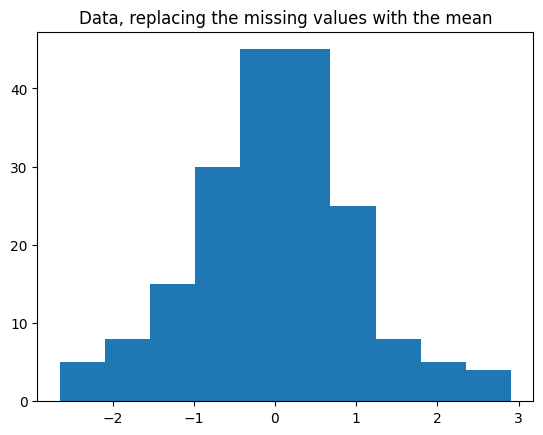

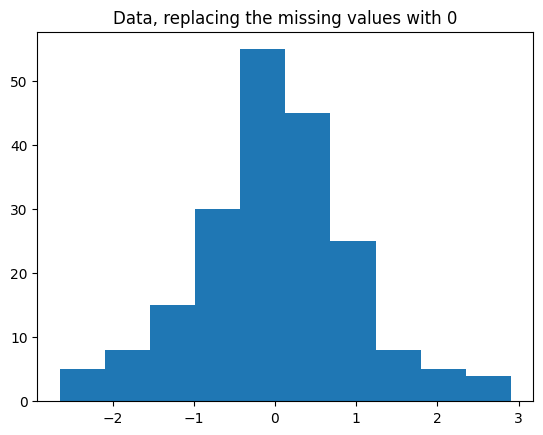

In [13]:
## Replace
# This is a normal distirbution (from the definition), but it's good to look at the distribution without NaNs before you pick a replacement value
# Could be better to use a mode or median! 

data_replaced = pd.DataFrame(data).fillna(data.mean())

plt.hist(data_replaced)
plt.title("Data, replacing the missing values with the mean")
plt.show()

# Let's see how we can bias the data here 
data_replaced_zeros =  pd.DataFrame(data).fillna(0)

plt.hist(data_replaced_zeros)
plt.title("Data, replacing the missing values with 0")

plt.show()

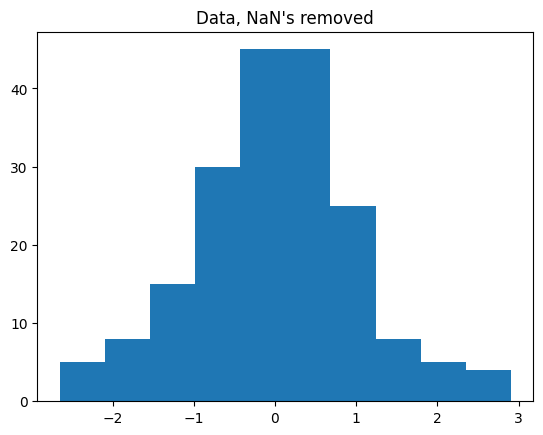

In [16]:
## Remove
# This method is a little easier, and probably better with such a well behaved problem
data_dropped = pd.DataFrame(data).dropna()

plt.hist(data_dropped)
plt.title("Data, NaN's removed")

plt.show()

### Data with outliers

Similarly to noisy data, if your data collection included possible errorsn in collection, points far outside the expected range, this can skew your results. 
Most likely, you don't want to account for these sort of outliers, or they're incredibly rare and satistically unimportant, you can throw them out. 

It is important to consider these outliers before you make a blanket statement that they're not useful, they could hold a clue to a problem upstream in the data collection procress, but this is not often the case. 
Sometimes there are just outliers. 

In this case, statitics can take care of us. 
You can use the quartiles to indentify the points widely outside the distirbution, and follow the same logic as if you were removing an NaN value. 
We'll use `np.quartile`, but pandas as identical functionality. 

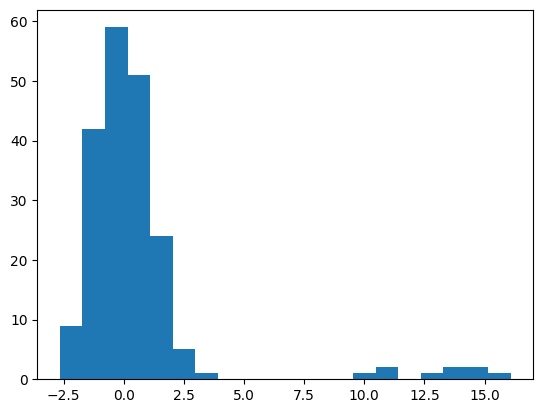

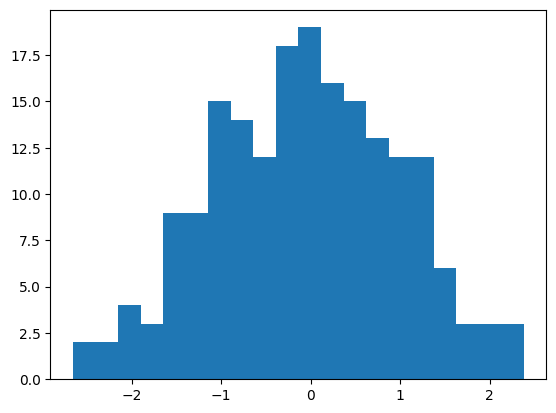

In [27]:
size = 200
data = np.random.default_rng().standard_normal(size=size)
remove_indices = np.random.default_rng().integers(0, size-1, size=int(size*.05)) # remove 5% of the data

data[remove_indices] = np.random.default_rng().uniform(10, 20, size=int(size*.05)) # Replace it with something.... different 

plt.hist(data, bins=20)
plt.show() #Wow 

# Remove those outliers. 

outliers = np.quantile(data, .95) # Take everything in the 95% quartile. A little outside what we expect

# Now let's use some indexing to remove this from the dataset 

non_outliers = data[data<outliers]
plt.hist(non_outliers, bins=20)
plt.show()


### Inbalanced Data 

Because not everything is equally likely, often you get datasets that are not perfectly even. 
This can cause a problem in training ML algorithms, because the model with learn to cheat and figure out that it can always select class A if class A is 95% of the dataset, and still get 95% accuracy. 
This sort of problem is obvious in problems like outlier detection (ex, fraud prevention, rare event tagging), but present to a degree in most (if not all) classification tasks. 

There's two main ways to solve this: 

_1. Selective Sampling_

Also called stratified sampling, this means sampling a larger class down to the size of the smaller class. 
This is an approach best done when the data is biased, but not enough that one of the classes is TINYYYY compared to the other. 
Remember, this does throw out data from the larger class, so make sure your sub-samble is still representive of the class as a whole. 
Generally a uniform sampling scheme will work well enough, but running some comparisons between your sub-sample and the whole class is good practice. 

_2.Label Weighing_

This method is better for highly imbalanced problems.
When you weight labels, it means that you apply more importance to the smaller class in the loss function. 
So, if you have a 100/10 split in classes, but weight them 1:10, the loss function will treat the loss from any of the smaller class with 10x the gravity as anything from the dominate class. 
Basically, you just make your loss REALLY care about the smaller class, comparitively. 

In [33]:
def generate_data(class_a_count, class_b_count): 
    rand = np.random.default_rng(42)
    
    class_a_features = rand.integers(-50, 0, class_a_count)
    class_b_features = rand.integers(1, 50, class_b_count)

    features = np.concatenate([class_a_features, class_b_features])
    rand.shuffle(features)
    labels = np.where(features>=0, 1,0)

    return features, labels

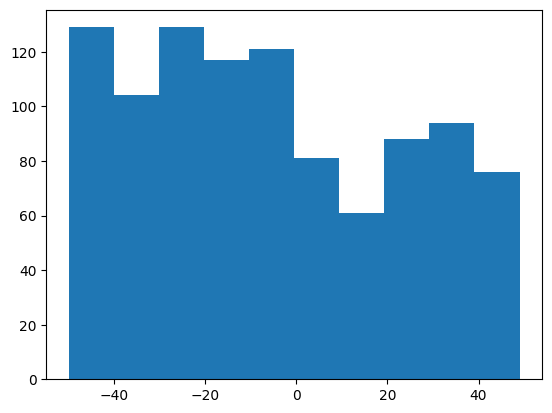

In [34]:
slightly_imbalanced_data = generate_data(600, 400)
plt.hist(slightly_imbalanced_data[0])
plt.show() 

# This is a common situation. This sort of imbalance can be because of either - 

# actual underlying problities
# sampling error

#Typically, you an imbalance this small, unless it's a high precision case, can be left as it for the model to handle

In [42]:
# Let's take care of this imbalance with some stratified sampling. 
# There are a few things to know here - We are going to remove data 
# So in multivariate training cases, we need to make sure we're not removing data that matters in a different dimension
# Also, when we do a train/val split, we may just get more samples of one class in another set than the other
# That doesn't need this sort of sampling to

# Let's use pandas to do the sampling
data = pd.DataFrame({"features": slightly_imbalanced_data[0], "label":slightly_imbalanced_data[1]})
data['label'].value_counts() # Exactly as we defined in the data generator 

0    600
1    400
Name: label, dtype: int64

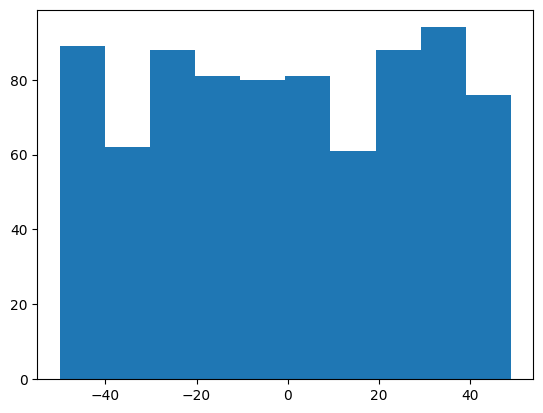

In [43]:
# Let's sample 
class_a = data[data["label"]==0] # isolate the class we want to downsample, the larger class here 
class_b = data[data["label"]==1]

downsample_count = len(class_b) # number of examples of class b. 
downsampled_class_a = class_a.sample(downsample_count) # Using `.sample` works across all columns, so the indexes are right

# And then go ahead and make the new dataset that's the combination of the other class, and this downsampled class 
even_dataset = pd.concat([downsampled_class_a, class_b])

plt.hist(even_dataset['features'])
plt.show()

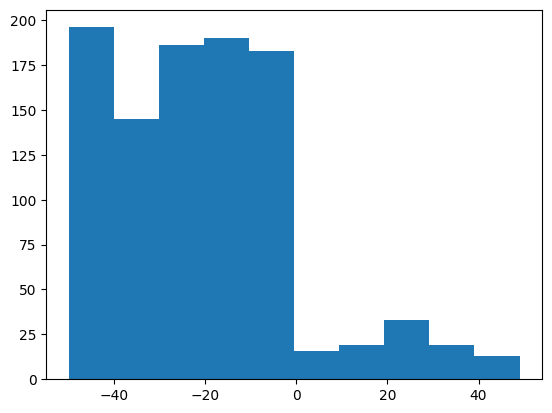

In [36]:
very_imbalanced_data = generate_data(900, 100)
plt.hist(very_imbalanced_data[0])
plt.show() 

# This. Is a big imbalance. This is almost certainly due to a underlying imbalance. 
#  We'll need to account for this in training. 

2023-06-14 10:29:15.627053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


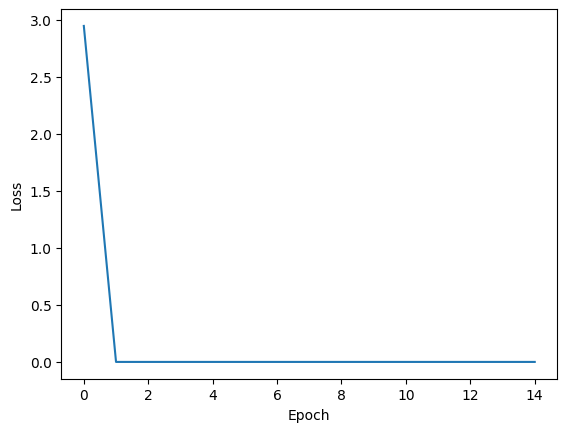

In [45]:
def make_model(): 
    inputs = Input(shape=(1,))
    dense = Dense(200)(inputs)
    dense = Dense(200)(dense)
    output = Dense(1)(dense)

    model = Model(inputs, output)
    model.compile(loss="binary_crossentropy", optimizer="sgd")
    return model

# Now in Kera's `fit` method, you can supply a "class_balance". This modifies the way loss is calculated, so that error associated with each label is balanced with a weight

model = make_model()
history = model.fit(
    x = very_imbalanced_data[0], 
    y = very_imbalanced_data[1], 
    class_weight = {0:1, 1:10}, #Making sure that a 1 is given 10x the weight of a 0. 
    epochs=15, 
    verbose=0
).history 

loss = history['loss']
epochs = range(len(loss))

plt.plot(epochs, loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show() # It gets pretty good at this pretty quick

### Large Variance in Scale

When your variables correlate to real world parameters, they are often in different units and different scales. 
Imagine you are trying to train a model to predict the difference between a cookie recipe and a cake recipe. 
So you would have the amount of milk in a unit like liters, and flour in grams. 
This ends up asking for something like .15 liters of milk and 150 grams of flour. 
The model is going to understand these numbers very differently, so it may put a large amount of importance on a variable you don't really need it to. 
(To a model, the difference between .2 L and 1 L is still smaller than 150 g to 145g!
It only sees the numbers and how they relate to the labels, not the real meaning of the number, no matter how much LLMs want you to think otherwise.) 

To fix this, we can scale the units (such converting liters in milliliters,) or normalizing each row to take values between 0 and 1. 
Because not every value in the world has units, in AI we generally take the later approach. 
We can also normalize (where we assume the data fits a normal distribution and scale using the mean and standard deviation of the dataset.)

In [30]:
size = 400
scale_data = pd.DataFrame({
    "milk": np.random.default_rng().uniform(0, 1, size=size), 
    "flour": np.random.default_rng().uniform(50, 140, size=size)
})
# Take the PCA to show what data has what variance

from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(scale_data)

# Note that one has All the variance. It's huge. But the data is random so one shouldn't explain more than the other
pca.explained_variance_

array([6.47202407e+02, 7.75237447e-02])

In [33]:
# Scale between 0 and 1. 

normalized_data = scale_data.copy() 
normalized_data.milk = (scale_data.milk - scale_data.milk.min())/(scale_data.milk.max() - scale_data.milk.min())
normalized_data.flour = (scale_data.flour - scale_data.flour.min())/(scale_data.flour.max() - scale_data.flour.min())

pca = PCA(n_components=2).fit(normalized_data)

# Much more even now
pca.explained_variance_

array([0.08123015, 0.07990267])

### Out-Of-Domain Data 

Non-Representive Data (or out-of-domain data) is the problem where the features you have between different inferences of your model are not the same. 
This is common when doing things like moving from simulation to non-simulation data, or when you gather new data to expand your training set. 
Unfortunately, this has no Easy fix.
But, it's a whole field of study. 
Check out the wikipedia page for [Domain Adaptation](https://en.wikipedia.org/wiki/Domain_adaptation). 

But, you can see a near identical situation from incorrectly scaling your input data. 

If your original work was done on a PCA-transformed dataset, you'll need to use the same fit transform to fit your validation data or any other data you preform inference on.
Same goes for scaling, normalization, you name it. 
If it's a transform applied to your training data, it has to be applied to further input data. 

In [3]:
# Using the keras functional api - docs located here: https://keras.io/guides/functional_api/

inputs = Input(shape=(5,))
dense = Dense(200)(inputs)
dense = Dense(200)(dense)
output = Dense(1)(dense)

model = Model(inputs, output)
model.compile(loss="mse", optimizer="sgd")

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-06-13 15:42:20.140307: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-13 15:42:20.140626: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
# Troubled Training 
def true_function(x): 
    return np.sum(np.sin(x), axis=1)

train_x = np.random.default_rng().uniform(low=-50, high=50, size=(200, 5))
train_y = true_function(train_x)

val_x = np.random.default_rng().uniform(low=-50, high=50, size=(200, 5))
val_y = true_function(val_x)


train_x = MinMaxScaler().fit_transform(X=train_x) # Spot the issue

model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), epochs=80, verbose=0) 
   # Takes a bit to run; you can turn this verbosity to 1 if you want to see the progress

# Calling model(data) gives you predictions 
model_preformance = mean_squared_error(y_true=train_y, y_pred=model(train_x))

model_validation_preformance = mean_squared_error(y_true=val_y, y_pred=model(val_x))

print(model_preformance)
print(model_validation_preformance) #Hm. Yikes! 

2.0138136514787797
1379.3406450338919


In [14]:
# Correction 

train_x = np.random.default_rng().uniform(low=-50, high=50, size=(200, 5))
train_y = true_function(train_x)

val_x = np.random.default_rng().uniform(low=-50, high=50, size=(200, 5))
val_y = true_function(val_x)

# The transform is a single instance
fit_transform =  MinMaxScaler().fit(X=train_x) 
# This is only fit to the train data, because val has the exact same range and behavoir. 
# However, if your val set has a single value outside the train set, this can cause problems for that value. 
# To get around this, you fit the transfrom to the union of train and val. (This doesn't ruin your val set purity, so it's fine)

train_x = fit_transform.transform(train_x)
val_x = fit_transform.transform(val_x)

model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), epochs=80, verbose=0) 
   # Takes a bit to run; you can turn this verbosity to 1 if you want to see the progress

# Calling model(data) gives you predictions 
model_preformance = mean_squared_error(y_true=train_y, y_pred=model(train_x))

model_validation_preformance = mean_squared_error(y_true=val_y, y_pred=model(val_x))

print(model_preformance)
print(model_validation_preformance) # Much more reasonable! 

2.4449181420244157
2.755266370089671


## Training Problems

### Improper Loss Function 

The loss function is how we quanitify good quality for a model.
It's also the metric the optimizer uses to take a gradient. 
This means, if it's not set up correctly, your model will not learn the proper result (if it learns anything at all.)

There are two main errors you hit here: 

_1. The loss function does not match the task type._

This means the function is not looking for agreement between your labels and your prediction, as you want them to be find. 
You see this most commonly when a classification problem is a incorrectly classed as a regression task. 
This means the loss function (generally mse or mae) is judging how close the continious distribution of outputs is to a discrete labels. 

_2. The loss function does not match the information you care about being correct._

A more specific subset of problem 1. 
This generally happens when you have a problem that cares a lot about specific properties of the outcome. 
The most logical example is if you are modeling energy of an item moving near the speed of light. 
There is an exact law you need your results to follow, but if you supply to your loss function that nothing can have an energy that breaks conservation laws, the model will not know anything about it, and may find ways to cheat that would be unexpected. 

2023-06-14 08:01:05.604143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-14 08:01:05.814361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


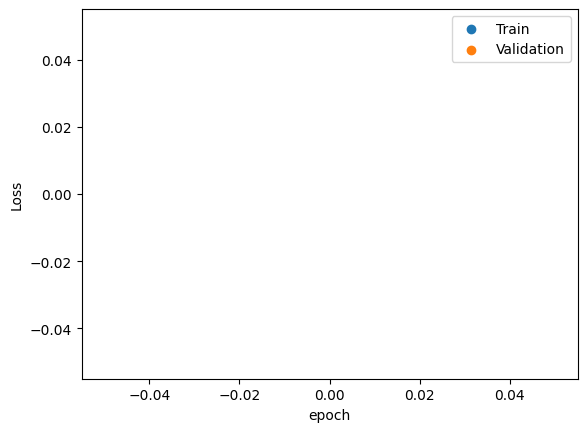

{'loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'val_loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]}


In [21]:
# Spot the problem: 

def make_model(input_size, loss_function, output_size): 
    inputs = Input(shape=(input_size,))
    dense = Dense(200)(inputs)
    dense = Dense(200)(dense)
    output = Dense(output_size)(dense)

    model = Model(inputs, output)
    model.compile(loss=loss_function, optimizer="sgd")
    return model 

def plot_history(history): 
    train_loss = history["loss"]
    val_loss = history['val_loss']

    epoch = range(len(train_loss))

    plt.scatter(epoch, train_loss, label='Train')
    plt.scatter(epoch, val_loss, label='Validation')

    plt.xlabel("epoch")
    plt.ylabel("Loss")

    plt.legend()
    plt.show()


def true_function(x): 
    summation = np.sum(x, axis=1)
    summation_sign = np.where(summation>=0, 1, 0) 
    # np.where is a conditional 
    # that replaces everything that meets the critea with the first value, and everything that doesn't with the second. 
    return summation_sign


train_x = np.random.default_rng().uniform(low=-50, high=50, size=(200, 5))
train_y = true_function(train_x)

val_x = np.random.default_rng().uniform(low=-50, high=50, size=(200, 5))
val_y = true_function(val_x)

model = make_model(input_size=5, loss_function="mse", output_size=1)

# This still trains the model (any prediction with `model` will still use the trained weights)
# This 'history' object just shows the loss as a function of epoch in a dictionary

history = model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), epochs=20, verbose=0).history 


plot_history(history) # Yeah. There's nothing here! Failed to start!
print(history)


2023-06-14 08:01:22.405303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-14 08:01:22.850267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


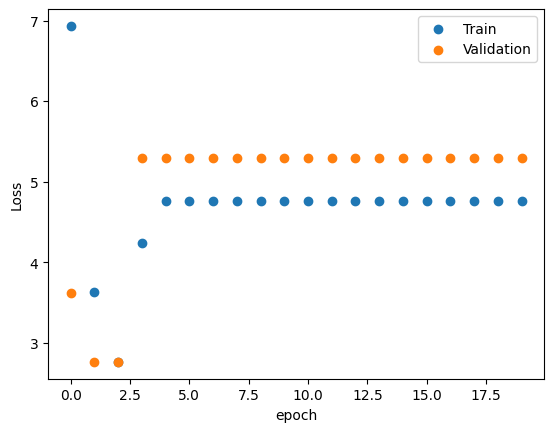

{'loss': [6.932791709899902, 3.6286628246307373, 2.7627909183502197, 4.240379333496094, 4.757134437561035, 4.757134437561035, 4.757134914398193, 4.757134437561035, 4.757134914398193, 4.757134914398193, 4.757134914398193, 4.757134914398193, 4.757134914398193, 4.757134914398193, 4.757134914398193, 4.757134437561035, 4.757134914398193, 4.757134437561035, 4.757134437561035, 4.757134437561035], 'val_loss': [3.623901605606079, 2.7624340057373047, 2.762439250946045, 5.293493747711182, 5.293493747711182, 5.293493747711182, 5.293493747711182, 5.293493747711182, 5.293493747711182, 5.293493747711182, 5.293493747711182, 5.293493747711182, 5.293493747711182, 5.293493747711182, 5.293493747711182, 5.293493747711182, 5.293493747711182, 5.293493747711182, 5.293493747711182, 5.293493747711182]}


In [22]:
# If you look at the true function - you can see this true function is a binary function 
# no wonder the mse had a hard time, you're trying to predict a classification task! You need a classification loss for that. 

# Lets use binary crossentropy, it's the stand loss for a binary (two class) classification task 
# Equation and description here: https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class


model = make_model(input_size=5, loss_function="binary_crossentropy", output_size=1)
history = model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), epochs=20, verbose=0).history 

plot_history(history)
print(history)

# Now this isn't great performance, but note that it does Actually train now
# Other changes, like learning rate tuning and optimization can help solve this. 

### Too high/too low learning rate

Learning rate is the first hyperparameter to come under fire when a training fails, and for good reason. 
Learning rate has a tendency to "skip" over both global and local minimum if it is too high, or never reach them at all if it is too low. 

_Identifying a learning rate problem_

When working with neural networks, the main metric we have to work with is loss. 
When your loss 

* remains static 
* refuses to move past a plateu it should be able to get past
* jumps all over the place

this is a tell-tale sign your learning rate is incorrect. 

_Solving a learning rate problem_ 

* Take a subset of your data, and try to train for a a few epochs. Play with your learning rate in small incrediments
* Decrease your learning rate if your loss jumps eratically
* Increase your learning rate if your loss doesn't move
* Try a [`Learning Rate Scheduler`](https://keras.io/api/callbacks/learning_rate_scheduler/)

If your problem happens later into training, you can use a [checkpoint](https://keras.io/api/callbacks/model_checkpoint/) that was trained up to an acceptable point, and play with the learning rate after that point. 

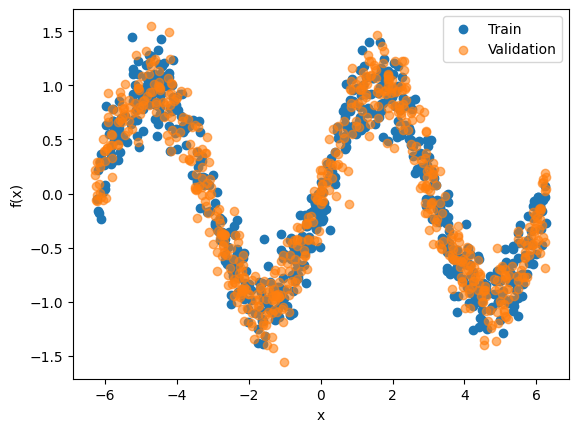

In [72]:
features = np.random.default_rng(42).uniform(-2*np.pi, 2*np.pi, 640)
labels = np.sin(features) + np.random.default_rng(42).normal(loc=0, scale=.2, size=640)

features_validation = np.random.default_rng(84).uniform(-2*np.pi, 2*np.pi, 640)
labels_validation = np.sin(features_validation) + np.random.default_rng(84).normal(loc=0, scale=.2, size=640)

plt.scatter(features, labels, label="Train")
plt.scatter(features_validation, labels_validation, label="Validation", alpha=.6)
plt.legend()
plt.xlabel('x')
plt.ylabel("f(x)")
plt.show()

2023-06-14 10:53:23.684051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


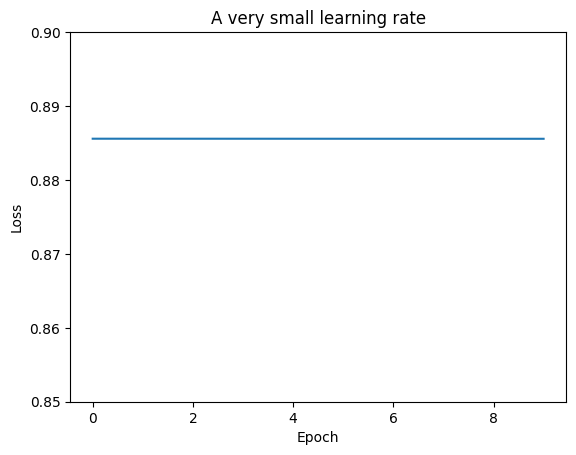

In [65]:
# To see what a loss curve looks like, let's make a REALLY small lr

inputs = Input(shape=(1,))
dense = Dense(200)(inputs)
dense = Dense(200)(dense)
output = Dense(1)(dense)

model = Model(inputs, output)
model.compile(loss="mse", optimizer=SGD(10**-9))

history = model.fit(features, labels, epochs=10, verbose=0).history

loss = history['loss']
epochs = range(len(loss))

plt.plot(epochs, loss)
plt.title("A very small learning rate")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([.85, .9])
plt.show() #This loss BARELY moves.

2023-06-14 10:53:37.187366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


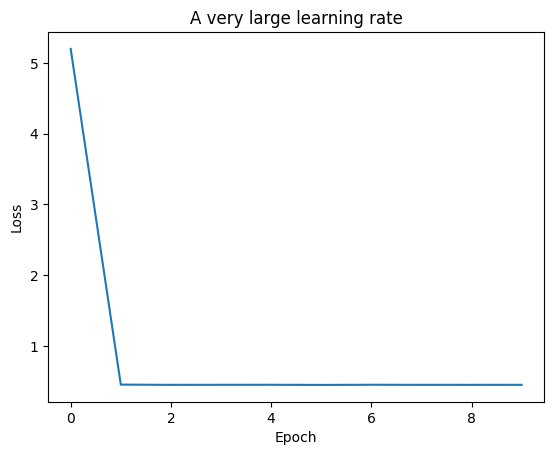

In [66]:
# In constrast, this is what a 

inputs = Input(shape=(1,))
dense = Dense(200)(inputs)
dense = Dense(200)(dense)
output = Dense(1)(dense)

model = Model(inputs, output)
model.compile(loss="mse", optimizer=SGD(.02))

history = model.fit(features, labels, epochs=10, verbose=0).history

loss = history['loss']
epochs = range(len(loss))

plt.plot(epochs, loss)
plt.title("A very large learning rate")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
# This is a huge loss by comparisive to the last one, and it just. Flattens and never moves. 

### Improper Optimizer

Different optimization algorithms have different properties. 
For example, an ADAM optimizer has a momentum property that will nudge it in the direction of the current gradient more than something like Stochastic Gradient Descent, which does not have this property. 
This means ADAM will generally converge faster, but can skip over acceptable local minima completely. 

_Identifying an optimizer problem_

Most often, a tell-tale sign of a optimizer-gone-off-the-rails is if you encounter a "vanishing" or "exploding" gradient during your training.
This means your loss will either dissapear into `-inf` or fly off into `inf`. 
That means your optimizer got stuck on your gradient. 

An improper optimizer also generally comes with a learning rate issue, so this is also worth investigating after you change an optimizer. 


_Solving an optimizer problem_

Unfortunately, the cookbook for this is a little sparse. 
The best recommendation is just to change the optimizer and try to train for a few epochs with a subset of your full data to see if your learning picked back up. 


### Underfit models

When a model isn't able to capture the information given in the data, we say it's "underfit" or "under-trained". 
You see this when either: Your model is not complicated enough to accurately capture the domain, or your data is too small/under-representive to show the model what your domain looks like 

_Identifying an underfit model_

* Your model preforms poorly on both validation and training dataset. 
* Your model gives anwsers completely outside the range of accepted anwsers

_Fixing an underfitting problem_

* Train for longer 
* Add complexity to your model (another dense layer, another convolution block, etc)
* Add pre-processing that simplifes your data or removes noise. 
* Give up and come back when you have more data (This is a real solution!)

It is also possible to mis-idenitify a learning rate problem as an underfitting problem, so also explore that possiblity! 

2023-06-14 11:04:32.658163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-14 11:04:32.900094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


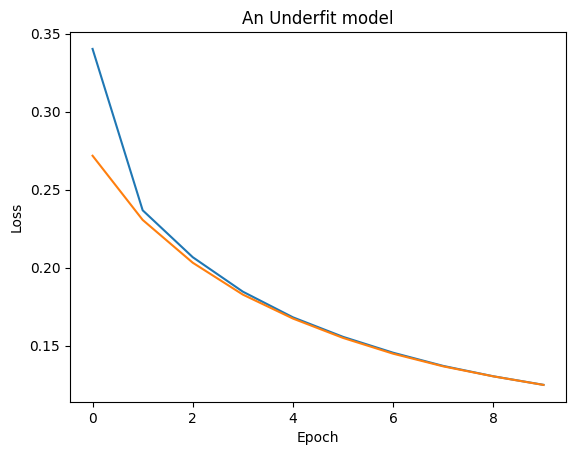

In [79]:
# Random data that cannot be fit actually - It's doomed to fail 
rng = np.random.default_rng()
features, labels = rng.random(1000), rng.random(1000)
features_validation, labels_validation = rng.random(1000), rng.random(1000)


inputs = Input(shape=(1,))
dense = Dense(40)(inputs)
output = Dense(1)(dense)

model = Model(inputs, output)
model.compile(loss="mse", optimizer=SGD())

history = model.fit(features, labels, validation_data=(features_validation, labels_validation), epochs=10, verbose=0).history

loss = history['loss']
epochs = range(len(loss))

val_loss = history['val_loss']

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)

plt.title("An Underfit model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# You can see the training curve is still trying to learn
# If you let it train further, you'd still see the curve drop

### Overfit models

"Overfit" is a general term meaning that the model knows how the training set behaves very well, but expects everything to behave like this. 
This causes problems if your training data does not cover every single possiblity. 
It only knows whats in the training set, and cannot interuperate to data points that lay between training points. 
For this reason, it's often called "memorization" as well. 

_Identifying an overfit model_

If your model: 
* Has a validation loss far larger than your training loss
* Has a test accuracy statistically lesser than your training accuracy

Your model is overfit. 

_Solving an overfitting problem_ 
* Stop training earlier. Use an [`early stopping callback`](https://keras.io/api/callbacks/early_stopping/) to stop training when validation loss plateaus
* Augment your data with noise or other noisy-preprocessing techniques
* Add weight [drop-out](https://keras.io/api/layers/regularization_layers/dropout/)
* Use a simplier model

2023-06-14 11:13:09.173562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-14 11:13:09.474129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


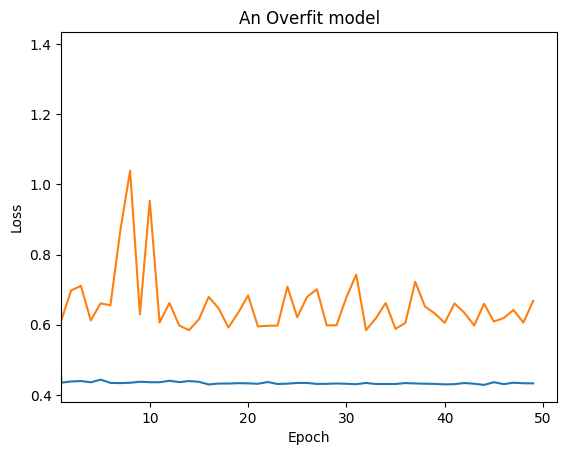

In [85]:
# I'm going to cheat a little and change the validation domain noise, just a tad 
# But this means that the model will learn the training data really well, but not know how to handle new validation data 
rng = np.random.default_rng()

features = rng.uniform(-2*np.pi, 2*np.pi, 1000)
labels = np.sin(features) + rng.uniform(low=0, high=.2, size=1000)

features_validation = rng.uniform(-2*np.pi, 2*np.pi, 1000) + rng.uniform(low=-.5, high=.5, size=1000)
labels_validation = np.sin(features) + rng.uniform(low=-.5, high=.5, size=1000)


inputs = Input(shape=(1,))
dense = Dense(40)(inputs)
dense = Dense(100)(dense)
output = Dense(1)(dense)

model = Model(inputs, output)
model.compile(loss="mse", optimizer=SGD())

history = model.fit(features, labels, validation_data=(features_validation, labels_validation), epochs=50, verbose=0).history

loss = history['loss']
epochs = range(len(loss))

val_loss = history['val_loss']

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)

plt.title("An Overfit model")
plt.xlabel("Epoch")
plt.xlim(left=1)
plt.ylabel("Loss")
plt.show()

## Coding problems

### Non-descriptive variables

If you write code and go back to read it a week later only to say "What sort of animal wrote this!", you have fallen victim to your own coding practice.
It's a classic way for a programmer to go. 

There are a lot of things that cause you to look at old code and throw up your hands, but undescriptive variables are both the most common and easiest to fix. 
Your naming should follow a few rules: 

1. Your variable name should say what the variable is

`x` becomes `?????????` 

(Never name your variable `x`. 
No one knows what `x` is.) 

2. Avoid using abbrivations outside specific contexts where those abbrivations are well understood

If you are writing pure math code, where the abbrivations are the variable, this is fine, but this is a special case. 
Most of the time, if you need an index, state explicitly it's an index. 
Don't just use `i` and `j` because they're easy, explicitly stating what they're indexing over will save you so much grief in the future. 

`leg_hands` becomes `legend_handles` 

`n_x` becomes `number_features`

3. Don't tack on version numbers to a variable

If you've ever written a paper and iterated over versions and ended up with "paper_final_v7_v2_final_for_real_v1.pdf", and send that to a professor just to realize that you should have sent "paper_final_v7_v2_final_for_real_v1_FOR_REAL.pdf" instead, you know why this is an important issue. 
The same thing can happen in code. 

`array_2` becomes `array_summed_sines`

### Overwriting variables

This is a feature of python. 
Unless you state a variable is a copy of another, you can accidentally modify the original variable. 

There are two ways this can happen: 
1. Overwriting through multiable types 

If you pass a variable to a function, and it's a multiable (it can be changed after definition without reassignment, something like a list or a dictionary), if it shares a namespace with something in the main body of the code, you can accidentally modify that instead of just the thing in the function. 

Classic example: 

```
the_list = []
def append_item(the_item): 
    the_list.append(the_item)
```

Will result in `the_list`, outside the function, being added onto. 
This can be a fine thing, if it's intended, but if not, it will confuse you. 

2. Incorrect copying

Sometimes, you want modify a copy of a certain variable, but keep the original.
If you do this with 
```
new_version = old_version
new_version[0] = 'the new thing'
```

to your shock, you may find that `old_version[0] == 'the new thing'` too! 
This is because you didn't make a copy. 
In python, name re-assignement does not make a new variable, it just makes a second name for the same variable. 

Instead, use `new_version = old_version.copy()` using the [copy method built into python](https://docs.python.org/3/library/copy.html)


### Path Problems

Bane of AI programmers everywhere is running a big piece of training code, going to save the results, and the program crashing. 
Or even worse, you've spent hours wrangling data, and when you go to load it into your model, it's no where to be found. 

Both of these are classic path problems, and there are some safe-guards and bug fixes you can put in place to help. 



1. Using `os.path.exists()`

When you write up some code and try to save it to a certain location, if you try to save it to somewhere that doesn't exists (yet), the code will often crash. 
You can get around this by A- keeping your saving location as a variable, B- creating the folders before you save a file. 
The block of code below gives an example. 

In [34]:
# Will throw an error
your_text = "hello world"

outpath = "./new_folder/example_text.txt"
with open(outpath, 'w') as f: 
    f.write(your_text)

FileNotFoundError: [Errno 2] No such file or directory: './new_folder/example_text.txt'

In [39]:
# Does not throw an error: 

base_dir = os.path.dirname(outpath) # get just the directories that need to be made

if not os.path.exists(base_dir): #verify the path doesn't already exist 
    os.makedirs(base_dir) # Throws an error if it tries to make folders that already exist, so put it in this if loop. 

with open(outpath, 'w') as f: 
    f.write(your_text)

In [41]:
# verify it saved, `cat` is a cli command that prints the content of a file 
! cat "./new_folder/example_text.txt"

hello world

2. You can't find a file you made

Assuming you saved a file somewhere, and when you go to read it in, you can sometimes get a pesky `FileNotFound` error! 
Unless something's gone wrong at a different step, this is probably because 

* a) The file wasn't saved where you thought it was 
* b) You aren't where you think you are 

To solve both of these, we can use some cli commands. 

Firstly, you can use `pwd` to show your current working directory. 
Is it where you think you are? 
If not, you may need to change your working directory, by either moving your notebook manually, or by using `sys.path.append("")`

However, in most cases, the easier solution is to move the file you want to read. 
If you don't know where it ended up, you can search for it with `ls` (and chances are you made a typo tying the file name, so you can copy the name when you see it now). 
Most cli also have a feature where you can press `Tab` when writing a path, and it will either autocomplete to the most common name (be that the next directory down, or the prefix multiple files in the directory use) or the next directory down.
If you press tab and the file you're looking for doesn't auto-complete, it's down into the file search tree with you. 

The next corrective step is to open your full file structure in some sort of gui (jupyter lab or vscode are common options), and find the file through that file tree, and then right click/ctrl click and `Copy Path`. 


In [42]:
# pwd - Show your current working path
! pwd

# ls, show the contents of your current working directory.  
! ls

# ls <dir>, show the contents of <dir>
! ls . 

/Users/maggiev-local/repo/SummerSchool2023
DAY6_ Intro to CNNs (Classifying Galaxy Mergers).ipynb
LICENSE
README.mkd
challenge_main.ipynb
common_pitfalls.ipynb
DAY6_ Intro to CNNs (Classifying Galaxy Mergers).ipynb
LICENSE
README.mkd
challenge_main.ipynb
common_pitfalls.ipynb


3. You can't import a script you wrote

This one gets more complicated. 
Python cannot work with scripts that aren't in packages for the most part, so if you have a folder of code you want to import, there are a few things you need to do beforehand. 

* Include an `__init__.py` file 

The `__init__.py`, even if it is completely empty, tells the python complier that the folder is a python package and to import all the names within the directory. Once you have an `__init__.py` in the folder, you can import any functions or classes from files in that directory. 

* Change your working directory

This is all dependent on your file strucutre.
If you have a few nested folders, and your code is in one folder, and the place you're using it is in another place, you'll run into problems. 
You can solve this by adding it to your envoriment, if your code is a full package, with `pip install <path to your code>`, which will work in most cases. 
Sometimes this is overkill, and you can just fake your wokring directory with the same trick we talked about in 2, using `sys.path.append("")`

This can cause problem down the road (as in, if you save a file it will save it as if you are in that directory, so be careful! 
Print out the places your files are saved to to make sure you put everything in the right place!)
